# This notebook uses pytorch lightning & optuna & an LSTM

This notebook trains an LSTM on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import pytorch_lightning as pl
import optuna
from optuna.integration import PyTorchLightningPruningCallback


import math


In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from neural_processes.models.model import LatentModel
from neural_processes.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
# from neural_processes.plot import plot_from_loader
from neural_processes.models.lstm import SequenceDfDataSet, LSTM_PL, plot_from_loader
from neural_processes.dict_logger import DictLogger
from neural_processes.utils import PyTorchLightningPruningCallback
from neural_processes.train import main, objective, add_number, run_trial

In [5]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [6]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [7]:
df_train, df_test = get_smartmeter_df()

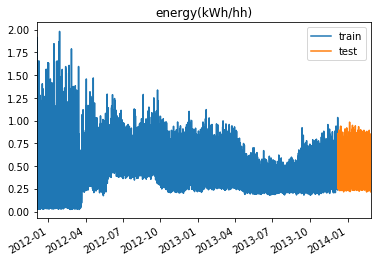

In [8]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

In [10]:
# def add_suggest(trial):
#     trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
#     trial.suggest_uniform("lstm_dropout", 0, 0.75)
#     trial.suggest_categorical("hidden_size", [1, 2, 4, 8, 16, 32, 64, 128])    
#     trial.suggest_categorical("lstm_layers", [1, 2, 4, 8])    
#     trial.suggest_categorical("bidirectional", [False, True])    
    
#     # constants
#     trial.suggest_int("window_length", 24 * 4, 24 * 4)
#     trial.suggest_int("target_length", 24*4, 24*4)
#     trial.suggest_int("max_nb_epochs", 20, 20)
#     trial.suggest_int("num_workers", 4, 4)
#     trial.suggest_int("grad_clip", 40, 40)
#     trial.suggest_int("vis_i", 670, 670)
#     trial.suggest_int("input_size", 17, 17)
#     trial.suggest_int("batch_size", 16, 16)    
#     return trial

# Train

In [12]:
PERCENT_TEST_EXAMPLES = 0.3
EPOCHS = 2
DIR = Path(os.getcwd())
MODEL_DIR = DIR/ 'optuna_result'/ 'lstm'
name = "lstm1"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/lstm


[I 2020-01-29 08:42:54,398] Finished trial#8 resulted in value: 0.005635036621242762. Current best value is 0.005635036621242762 with parameters: {'batch_size': 16, 'bidirectional': False, 'grad_clip': 40, 'hidden_size': 128, 'input_size': 17, 'learning_rate': 0.00019134834148401144, 'lstm_dropout': 0.4080689425353674, 'lstm_layers': 8, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': 670, 'window_length': 48}.

Note that the LSTM has access to the y values for the first half of the plot (the context) to match the NP setup.

In [16]:
trial = optuna.trial.FixedTrial(
    params={
        'number': 45,
        'batch_size': 16,
        'bidirectional': False,
        'grad_clip': 40,
        'hidden_size': 128,
        'input_size': 17,
        'learning_rate': 2e-5,
        'lstm_dropout': 0.4,
        'lstm_layers': 8,
        'max_nb_epochs': 20,
        'num_workers': 4,
        'target_length': 24*4,
        'vis_i': '670',
        'window_length': 24*4
    })
trial = LSTM_PL.add_suggest(trial)
trial = add_number(trial, MODEL_DIR/name)
model, trainer = main(trial, train=False)
trainer.fit(model)

/media/wassname/Storage5/projects2/3ST/pytorch-lightning/pytorch_lightning/callbacks/pt_callbacks.py:239: UserWarning:

Checkpoint directory /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/lstm/lstm1/version_109/chk exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0


INFO:root:
            Name     Type Params
0         _model  LSTMNet    1 M
1   _model.lstm1     LSTM  999 K
2  _model.linear   Linear  129  
INFO:root:model and trainer restored from checkpoint: /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/lstm/lstm1/version_109/chk/_ckpt_epoch_3.ckpt


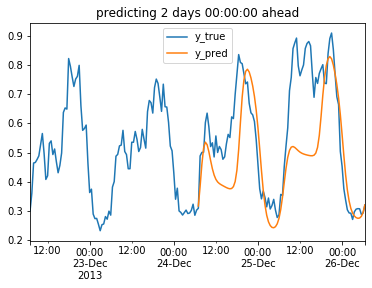

step 10973, {'val_loss': '0.015320336446166039'}



In [17]:
# test
trainer.test(model)

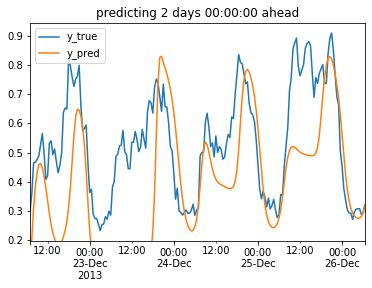

In [18]:
loader = model.val_dataloader()[0]
dset_test = loader.dataset
label_names = dset_test.label_names
plot_from_loader(loader, model, vis_i=670)

# Hyperparam opt

In [ ]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name='no-name-b60e37fc-4ab6-4793-8a0a-c87a1b40c5c0', load_if_exists=True)

# shutil.rmtree(MODEL_DIR)

In [ ]:
study.optimize(objective, n_trials=200, timeout=6000)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


In [ ]:
study.optimize(objective, n_trials=200, timeout=6000)

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

# Scratch

In [ ]:
model, trainer = main(trial, train=False)

In [ ]:
loader = model.val_dataloader()[0]
dset_test = loader.dataset
label_names = dset_test.label_names

In [ ]:
x_rows, y_rows = dset_test.iloc(10)
x_rows.loc[x_rows.index[model.hparams.window_length:], dset_test.label_names] = 0.
x_rows

In [ ]:
x_rows.loc[x_rows.index[model.hparams.window_length:]]

In [ ]:
self=dset_test
idx=10
k = idx + self.hparams.window_length + self.hparams.target_length
j = k - self.hparams.target_length
i = j - self.hparams.window_length
idx, k, j, i, self.hparams.window_length + self.hparams.target_length

In [ ]:
j-i

In [ ]:
self.hparams.window_length + self.hparams.target_length